In [23]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
import datetime
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import shutil
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from icelakes.utilities import convert_time_to_string
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks
from IPython.display import Image, display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# gdf_names = gpd.read_file('basins/shapefiles/GRE_fullnames_GIMP_merged.shp')

In [25]:
gdf_regions =  gpd.read_file('basins/shapefiles/ANT_basins_merged.shp')
gdf_imbie = gpd.read_file('basins/shapefiles/Basins_Antarctica_v02.shp')
gdf_shelf = gpd.read_file('basins/shapefiles/IceShelf_Antarctica_v02.shp')
gdf_names = pd.concat((gdf_imbie.drop(columns=['Asso_Shelf', 'Subregions']),
                       gdf_shelf)).reset_index(drop=True)

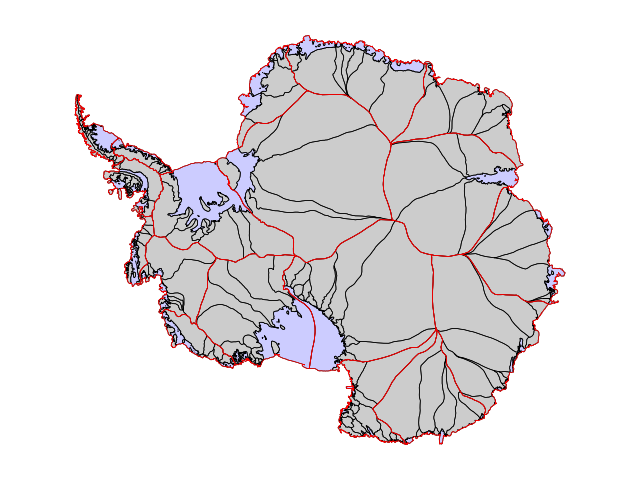

In [26]:
fig, ax = plt.subplots()
gdf_imbie.plot(ax=ax, color='k', alpha=0.2)
gdf_shelf.plot(ax=ax, color='b', alpha=0.2)
gdf_names.boundary.plot(ax=ax, lw=0.5, color='k')
gdf_regions.boundary.plot(ax=ax, lw=0.5, color='r')
ax.axis('off')
fig.tight_layout()

In [27]:
base_dir = '../GLD3_complete/AIS/'
context_dir = 'detection_context/'
imagery_dir = 'detection_imagery/'
data_dir = 'detection_out_data/'
plot_dir = 'detection_out_plot/'

good_dir = 'good_lake/'
bad_depth_dir = 'lake_bad_depth/'
nolake_dir = 'bad_no_lake/'

In [28]:
searchfor = '_context.jpg'

# good lakes
searchdir = base_dir + context_dir + good_dir
filelist = [searchdir+f for f in os.listdir(searchdir) if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist.sort()
print('There are %i good lake files.' % len(filelist))
fl = [x.split('/')[-1].replace('_context.jpg','') for x in filelist]
df_good = pd.DataFrame({'lake_id': fl, 'label': good_dir.replace('/','')})

# lakes with bad depth
searchdir = base_dir + context_dir + bad_depth_dir
filelist = [searchdir+f for f in os.listdir(searchdir) if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist.sort()
print('There are %i bad depth lake files.' % len(filelist))
fl = [x.split('/')[-1].replace('_context.jpg','') for x in filelist]
df_bad = pd.DataFrame({'lake_id': fl, 'label': bad_depth_dir.replace('/','')})

# lakes that aren't lakes 
searchdir = base_dir + context_dir + nolake_dir
filelist = [searchdir+f for f in os.listdir(searchdir) if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist.sort()
print('There are %i no lake files.' % len(filelist))
fl = [x.split('/')[-1].replace('_context.jpg','') for x in filelist]
df_nolake = pd.DataFrame({'lake_id': fl, 'label': nolake_dir.replace('/','')})
df_nolake

df_labels = pd.concat([df_good, df_bad, df_nolake]).reset_index(drop=True)
df_labels

There are 3559 good lake files.
There are 319 bad depth lake files.
There are 18259 no lake files.


,lake_id,label
0,lake_097349_AIS_2021-22_simplified_ANT_1000_Ea...,good_lake
1,lake_097459_AIS_2020-21_simplified_ANT_1000_Pe...,good_lake
2,lake_097503_AIS_2019-20_simplified_ANT_1000_Ea...,good_lake
3,lake_097556_AIS_2019-20_simplified_ANT_1000_Ea...,good_lake
4,lake_097877_AIS_2019-20_simplified_ANT_1000_Ea...,good_lake
...,...,...
22132,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake
22133,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake
22134,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake
22135,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake


# move the files

In [29]:
# for idx in df_labels.index:

#     x = df_labels.loc[idx].copy()
    
#     fc = base_dir + data_dir + x.lake_id + '.h5'
#     moveto = base_dir + data_dir + x.label + '/'
#     if not os.path.exists(moveto):
#         os.makedirs(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - data does not exist: %s' % (idx,fc))
    
#     fc = base_dir + imagery_dir + x.lake_id + '_imagery.tif'
#     moveto = base_dir + imagery_dir + x.label + '/'
#     if not os.path.exists(moveto):
#         os.makedirs(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - imagery does not exist: %s' % (idx,fc))
    
#     fc = base_dir + plot_dir + x.lake_id + '_quicklook.jpg'
#     moveto = base_dir + plot_dir + x.label + '/'
#     if not os.path.exists(moveto):
#         os.makedirs(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - quicklook image does not exist: %s' % (idx,fc))
    
#     fc = base_dir + plot_dir + x.lake_id + '_details.jpg'
#     moveto = base_dir + plot_dir + x.label + '/'
#     if not os.path.exists(moveto):
#         os.makedirs(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - details image does not exist: %s' % (idx,fc))

In [30]:
# # bad lakes, fix this later
# to_remove = [
#     'lake_099908_AIS_2018-19_simplified_ANT_1000_West_J-Jpp_ATL03_20190203020131_05590211_006_02_gt1l_0000',
#     'lake_099999_AIS_2021-22_simplified_ANT_1000_West_J-Jpp_ATL03_20220331091725_01261512_006_01_gt1l_0001',
#     'lake_100000_AIS_2022-23_simplified_ANT_1000_West_J-Jpp_ATL03_20230331022530_01481911_006_02_gt1r_0002',
#     'lake_100000_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190212165420_07060210_006_02_gt2r_0000',
#     'lake_099999_AIS_2018-19_simplified_ANT_1000_West_Ep-F_ATL03_20190117091719_03040211_006_02_gt3l_0005',
#     'lake_100000_AIS_2021-22_simplified_ANT_1000_East_K-A_ATL03_20220101093740_01541412_006_01_gt2r_0001',
#     'lake_099992_AIS_2019-20_simplified_ANT_1000_East_K-A_ATL03_20191104231510_05960512_006_01_gt3l_0017',
#     'lake_099968_AIS_2021-22_simplified_ANT_1000_East_K-A_ATL03_20220318161149_13191410_006_01_gt3l_0000',
#     'lake_099979_AIS_2022-23_simplified_ANT_1000_West_G-H_ATL03_20221213091106_12771710_006_02_gt3r_0003',
# ]

# for idx, lid in enumerate(to_remove):
#     print('\n')

#     x = df_labels[df_labels.lake_id == lid].copy().iloc[0]

#     fc = base_dir + context_dir + x.label + '/' + x.lake_id + '_context.jpg'
#     moveto = base_dir + context_dir + nolake_dir
#     # print(fc)
#     # print(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - data does not exist: %s' % (idx,fc))
    
#     fc = base_dir + data_dir + x.label + '/' + x.lake_id + '.h5'
#     moveto = base_dir + data_dir + nolake_dir
#     # print(fc)
#     # print(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - data does not exist: %s' % (idx,fc))
    
#     fc = base_dir + imagery_dir + x.label + '/' + x.lake_id + '_imagery.tif'
#     moveto = base_dir + imagery_dir + nolake_dir
#     # print(fc)
#     # print(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - imagery does not exist: %s' % (idx,fc))
    
#     fc = base_dir + plot_dir + x.label + '/' + x.lake_id + '_quicklook.jpg'
#     moveto = base_dir + plot_dir + nolake_dir
#     # print(fc)
#     # print(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - quicklook image does not exist: %s' % (idx,fc))
    
#     fc = base_dir + plot_dir + x.label + '/' + x.lake_id + '_details.jpg'
#     moveto = base_dir + plot_dir + nolake_dir
#     # print(fc)
#     # print(moveto)
#     if os.path.isfile(fc):
#         shutil.move(fc, moveto)
#     else:
#         print('%s - details image does not exist: %s' % (idx,fc))
    

In [31]:
exists = df_labels.apply(lambda x: os.path.isfile('%s%s%s/%s.h5' % (base_dir, data_dir, x.label, x.lake_id)), axis=1)
np.sum(~exists)

0

In [32]:
def get_attributes(r):
    fn = '%s%s%s/%s.h5' % (base_dir, data_dir, r.label, r.lake_id)
    try:
        with h5py.File(fn, 'r') as f:
            return pd.Series({
                'lon': f['properties']['lon'][()],
                'lat': f['properties']['lat'][()],
                'surface_elevation': f['properties']['surface_elevation'][()],
                'date_time': f['properties']['date_time'][()].decode('utf-8'),
                'depth_quality_sort': f['properties']['depth_quality_sort'][()],
                'max_depth': f['properties']['max_depth'][()],
                'beam_strength': f['properties']['beam_strength'][()].decode('utf-8')
            })
    except:
        return pd.Series({
                'lon': np.nan,
                'lat': np.nan,
                'surface_elevation': np.nan,
                'date_time': '',
                'depth_quality_sort': np.nan,
                'max_depth': np.nan,
                'beam_strength': ''
            })

df_labels = pd.concat((df_labels, df_labels.apply(get_attributes, axis=1)), axis=1)
df_labels

,lake_id,label,lon,lat,surface_elevation,date_time,depth_quality_sort,max_depth,beam_strength
0,lake_097349_AIS_2021-22_simplified_ANT_1000_Ea...,good_lake,70.539272,-72.021164,83.560240,2022-01-18T02:23:25Z,26.509377,3.386684,strong
1,lake_097459_AIS_2020-21_simplified_ANT_1000_Pe...,good_lake,-61.067558,-64.958758,88.053541,2021-01-04T16:31:35Z,25.413428,2.672345,strong
2,lake_097503_AIS_2019-20_simplified_ANT_1000_Ea...,good_lake,70.542509,-72.021683,81.763109,2020-01-22T13:04:36Z,24.965919,1.329850,strong
3,lake_097556_AIS_2019-20_simplified_ANT_1000_Ea...,good_lake,70.247095,-72.048084,77.611653,2020-01-18T00:29:08Z,24.439006,2.448652,weak
4,lake_097877_AIS_2019-20_simplified_ANT_1000_Ea...,good_lake,12.280324,-70.297277,23.635893,2020-01-16T04:28:35Z,21.227830,8.875638,strong
...,...,...,...,...,...,...,...,...,...
22132,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake,-71.419828,-81.847279,426.662194,2023-03-29T01:43:12Z,0.000000,0.000000,weak
22133,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake,-67.606088,-84.621054,901.502559,2023-03-31T00:52:42Z,0.000000,0.000000,weak
22134,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake,-79.892143,-79.558632,380.534583,2023-03-31T02:25:36Z,0.000000,0.000000,strong
22135,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake,-82.289380,-81.335870,964.177600,2023-03-31T02:26:05Z,0.000000,0.000000,strong


In [33]:
df_labels[df_labels.lon.isna()]

,lake_id,label,lon,lat,surface_elevation,date_time,depth_quality_sort,max_depth,beam_strength


## Remove corrupted data files that can't be opened

In [34]:
# for idx in df_labels[df_labels.lon.isna()].index:
    
#     x = df_labels.loc[idx].copy()
#     print('\n%s' % x.lake_id)
    
#     fc = base_dir + data_dir + x.lake_id + '.h5'
#     print(fc)
#     if os.path.isfile(fc):
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('no context image exists')
    
#     fc = base_dir + context_dir + x.label + '/' + x.lake_id + '_context.jpg'
#     print(fc)
#     if os.path.isfile(fc):
#         display(Image(fc))
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('no context image exists')
    
#     fc = base_dir + imagery_dir + x.lake_id + '.tiff'
#     print(fc)
#     if os.path.isfile(fc):
#         print('imagery exists')
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('imagery does not exist')
    
#     fc = base_dir + plot_dir + x.lake_id + '_quicklook.jpg'
#     print(fc)
#     if os.path.isfile(fc):
#         display(Image(fc))
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('quicklook image does not exist')
    
#     fc = base_dir + plot_dir + x.lake_id + '_details.jpg'
#     print(fc)
#     if os.path.isfile(fc):
#         display(Image(fc))
#         print('file exists, deleting')
#         os.remove(fc)
#     else:
#         print('quicklook image does not exist')

# df_labels = df_labels[~np.isnan(df_labels.lon)].reset_index(drop=True)

# save the labels

In [35]:
df_labels.to_csv(base_dir + 'lake_labels.csv', index=False)

## quick plot of label vs. depth_quality_sort

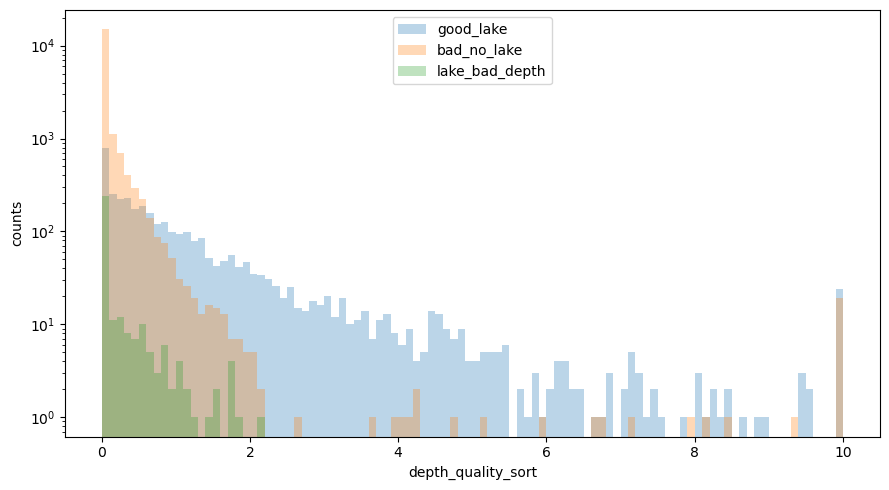

In [36]:
# df_labels = pd.read_csv(base_dir + 'lake_labels.csv')
fig, ax = plt.subplots(figsize=(9,5))

maxval = 10
al = 0.3
bins = np.linspace(0, maxval, 101)
dft = df_labels[df_labels.label == 'good_lake']
ax.hist(np.clip(dft.depth_quality_sort, 0, maxval), bins=bins, color='C0', alpha=al, label='good_lake')
dft = df_labels[df_labels.label == 'bad_no_lake']
ax.hist(np.clip(dft.depth_quality_sort, 0, maxval), bins=bins, color='C1', alpha=al, label='bad_no_lake')
dft = df_labels[df_labels.label == 'lake_bad_depth']
ax.hist(np.clip(dft.depth_quality_sort, 0, maxval), bins=bins, color='C2', alpha=al, label='lake_bad_depth')

ax.set_yscale('log')

ax.set_xlabel('depth_quality_sort')
ax.set_ylabel('counts')

ax.legend(loc='upper center')

fig.tight_layout()
plt.close(fig)
display(fig)

In [37]:
# df_files = df_labels[df_labels.label != 'bad_no_lake']
df_files = df_labels

# compile full list of lake stats

In [38]:
def get_lake_properties(r):
    # define properties to save
    vars = [
        'ice_sheet',
        'melt_season',
        'date_time',
        'lon',
        'lat',
        'surface_elevation',
        'depth_quality_sort',
        'max_depth',
        'cycle_number',
        'rgt',
        'gtx',
        'beam_strength',
        'beam_number',
        'sc_orient',
        'granule_id',
        'polygon_name',
        'lat_max',
        'lat_min',
        'lon_max',
        'lon_min',
    ]
    
    # the path of the file to read
    fn = '%s%s%s/%s.h5' % (base_dir, data_dir, r.label, r.lake_id)
    
    # open h5 file
    with h5py.File(fn, 'r') as f:
    
        # get properties
        dic = {k: v.decode('utf-8') if type(v)==bytes else v for k, v in {k: f['properties'][k][()] for k in vars}.items()}
    
        # figure out if depth data is available
        dic['has_depth_data'] = 'depth_data' in f.keys()
    
        # if depth is available, compute stats
        if dic['has_depth_data']:
    
            df = pd.DataFrame({k: f['depth_data'][k][()] for k in f['depth_data'].keys()})
            resolution = 5.0
            dfd = df[df.depth>0]
            dfc = dfd[dfd.conf>0.1]
    
            try:
                dic['conf_mean'] = dfd.conf.mean()
            except:
                dic['conf_mean'] = np.nan
    
            try:
                dic['conf_median'] = dfd.conf.median()
            except:
                dic['conf_median'] = np.nan
                
            try:
                dic['conf_q90'] = dfd.conf.quantile(0.90)
            except:
                dic['conf_q90'] = np.nan
    
            try:
                dic['length_water'] = dfc.xatc.diff().sum()
            except:
                dic['length_water'] = np.nan
    
            try: 
                dic['total_length'] = dfc.xatc.max() - dfc.xatc.min()
            except:
                dic['total_length'] = np.nan
    
            try:
                dic['depth_mean'] = dfc.depth.mean()
            except:
                dic['depth_mean'] = np.nan
                
            try:
                dic['depth_median'] = dfc.depth.median()
            except:
                dic['depth_median'] = np.nan
    
            try:
                is_depth = np.sum((df.depth > 0) & (df.conf > 0.1))
                dic['ratio_water'] = is_depth / len(df) 
            except:
                dic['ratio_water'] = np.nan
    
        # if depth is unavailable, return nans
        else:
            dic['conf_mean'] = np.nan
            dic['conf_median'] = np.nan
            dic['conf_q90'] = np.nan
            dic['length_water'] = np.nan
            dic['total_length'] = np.nan
            dic['depth_mean'] = np.nan
            dic['depth_median'] = np.nan
            dic['ratio_water'] = np.nan
    
        dic['polygon_name'] = dic['polygon_name'].replace('simplified_', '')
    
    return pd.DataFrame(dic, index=[r.name])

In [39]:
cols = []
nfiles = len(df_files)

for i, idx in enumerate(df_files.index):
    
    if (i+1) % 100 == 0:
        print('%5i / %5i' % (i+1, nfiles), end='\r')
        
    cols.append(get_lake_properties(df_files.loc[idx]))

print(' done')
df_props = pd.concat(cols)

 done / 22137


In [40]:
df_files.iloc[:,:2]

,lake_id,label
0,lake_097349_AIS_2021-22_simplified_ANT_1000_Ea...,good_lake
1,lake_097459_AIS_2020-21_simplified_ANT_1000_Pe...,good_lake
2,lake_097503_AIS_2019-20_simplified_ANT_1000_Ea...,good_lake
3,lake_097556_AIS_2019-20_simplified_ANT_1000_Ea...,good_lake
4,lake_097877_AIS_2019-20_simplified_ANT_1000_Ea...,good_lake
...,...,...
22132,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake
22133,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake
22134,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake
22135,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake


In [41]:
df_merged = pd.concat((df_files.iloc[:,:2], df_props), axis=1)
df_merged.head(3)

,lake_id,label,ice_sheet,melt_season,date_time,lon,lat,surface_elevation,depth_quality_sort,max_depth,...,lon_min,has_depth_data,conf_mean,conf_median,conf_q90,length_water,total_length,depth_mean,depth_median,ratio_water
0,lake_097349_AIS_2021-22_simplified_ANT_1000_Ea...,good_lake,AIS,2021-22,2022-01-18T02:23:25Z,70.539272,-72.021164,83.560240,26.509377,3.386684,...,70.535956,True,0.845393,0.885398,0.933739,1000.0,1000.0,2.811237,2.980471,0.712766
1,lake_097459_AIS_2020-21_simplified_ANT_1000_Pe...,good_lake,AIS,2020-21,2021-01-04T16:31:35Z,-61.067558,-64.958758,88.053541,25.413428,2.672345,...,-61.069069,True,0.441378,0.446672,0.812703,150.0,150.0,1.885977,2.323473,0.272727
2,lake_097503_AIS_2019-20_simplified_ANT_1000_Ea...,good_lake,AIS,2019-20,2020-01-22T13:04:36Z,70.542509,-72.021683,81.763109,24.965919,1.329850,...,70.539731,True,0.811347,0.852847,0.893655,895.0,895.0,0.881855,0.854832,0.687023


# Add the basin and subbasin names 

In [42]:
gdf_names = gpd.read_file('basins/shapefiles/GRE_fullnames_GIMP_merged.shp')
gdf_merged = gpd.GeoDataFrame(df_merged, geometry=gpd.points_from_xy(df_merged.lon, df_merged.lat), crs="EPSG:4326").to_crs(gdf_names.crs)

In [43]:
gdf_regions =  gpd.read_file('basins/shapefiles/ANT_basins_merged.shp')
gdf_imbie = gpd.read_file('basins/shapefiles/Basins_Antarctica_v02.shp')
gdf_shelf = gpd.read_file('basins/shapefiles/IceShelf_Antarctica_v02.shp')
gdf_names = pd.concat((gdf_imbie.drop(columns=['Asso_Shelf', 'Subregions']),
                       gdf_shelf)).reset_index(drop=True)
gdf_merged = gpd.GeoDataFrame(df_merged, geometry=gpd.points_from_xy(df_merged.lon, df_merged.lat), crs="EPSG:4326").to_crs(gdf_regions.crs)

In [44]:
gdf_regions

,Subregions,Regions,geometry
0,A-Ap,East,"POLYGON ((-217949.577 2132201.233, -218200.116..."
1,Ap-B,East,"POLYGON ((1580144.570 1194398.841, 1546993.222..."
2,B-C,East,"POLYGON ((906081.004 260430.871, 899939.375 26..."
3,C-Cp,East,"POLYGON ((2572424.590 -167174.927, 2572674.727..."
4,Cp-D,East,"POLYGON ((1999424.606 -1689425.565, 1999424.69..."
5,D-Dp,East,"POLYGON ((1132475.353 -2058817.367, 1131708.55..."
6,Dp-E,East,"POLYGON ((440222.827 -2038172.048, 441081.119 ..."
7,E-Ep,East,"POLYGON ((306799.994 -1293174.603, 306675.202 ..."
8,Ep-F,West,"POLYGON ((-672878.546 -1223262.434, -671299.75..."
9,F-G,West,"POLYGON ((-1423449.652 -1082800.420, -1424699...."


In [45]:
gdf_names

,NAME,Regions,TYPE,geometry
0,LarsenE,Peninsula,GR,"POLYGON ((-1604213.024 911528.811, -1603107.44..."
1,Academy,East,GR,"POLYGON ((-650479.108 590441.379, -644265.131 ..."
2,Brunt_Stancomb,East,GR,"POLYGON ((-549906.633 1305863.952, -572323.238..."
3,Riiser-Larsen,East,GR,"POLYGON ((-418449.622 1964493.872, -417441.371..."
4,Ekstrom,East,GR,"POLYGON ((-279374.614 2087161.462, -274979.688..."
...,...,...,...,...
375,ClarkeBay,Peninsula,FL,"POLYGON ((-1488154.393 826494.229, -1488283.93..."
376,Hayes_Coats_Coast,East,FL,"POLYGON ((-699140.992 1331574.824, -699232.533..."
377,Hannan,East,FL,"MULTIPOLYGON (((1828951.998 1646435.540, 18286..."
378,Rydberg_Peninsula_1,Peninsula,FL,"POLYGON ((-1817781.673 337199.389, -1817527.56..."


In [46]:
def get_lake_location_name(r):
    containing_polygon_regions = gdf_regions[gdf_regions.geometry.contains(r.geometry)]
    containing_polygon_names = gdf_names[gdf_names.geometry.contains(r.geometry)]
    
    if len(containing_polygon_regions) > 0:
        if len(containing_polygon_regions) == 1:
            v = containing_polygon_regions.iloc[0]
        else:
            print('%5i: WARNING - lake was assigned to two basins: ' % r.name, end='')
            for subid in containing_polygon_regions.index: 
                print('%s, ' % containing_polygon_regions.Subregions.loc[subid], end='')
            # just assign the one with the shorter name
            v = containing_polygon_regions.loc[containing_polygon_regions.apply(lambda x: len(x.Subregions), axis=1).idxmin()]
            print(' --> assigned: %s' % v.Subregions)
        infodict = {'basin': v.Subregions, 'region': v.Regions}
    else:
        print('%5i: WARNING - lake not assigned to any basins' % r.name)
        infodict = {'basin': 'none', 'region': 'none'}

    if len(containing_polygon_names) > 0:
        if len(containing_polygon_names) == 1:
            v = containing_polygon_names.iloc[0]
        else:
            print('%5i: WARNING - lake was assigned to two sub-basins: ' % r.name, end='')
            for subid in containing_polygon_names.index: 
                print('%s, ' % containing_polygon_names.NAME.loc[subid], end='')
            # just assign the one with the shorter name
            v = containing_polygon_names.loc[containing_polygon_names.apply(lambda x: len(x.NAME), axis=1).idxmin()]
            print(' --> assigned: %s' % v.NAME)
        infodict2 = {'sub_basin': v.NAME, 'grounded': False if v.TYPE=='FL' else True}
    else:
        print('%5i: WARNING - lake not assigned to any sub-basins' % r.name)
        infodict2 = {'sub_basin': 'none', 'grounded': 'none'}
        
    infodict.update(infodict2)
    return pd.DataFrame(infodict, index=[r.name])

In [47]:
cols = []
nfiles = len(gdf_merged)

for i, idx in enumerate(gdf_merged.index):
    
    if (i+1) % 100 == 0:
        print('%5i / %5i' % (i+1, nfiles), end='\r')
        
    cols.append(get_lake_location_name(gdf_merged.loc[idx]))

print(' done')
df_matched_names = pd.concat(cols)
df_matched_names

12696: WARNING - lake not assigned to any basins
12696: WARNING - lake not assigned to any sub-basins
14026: WARNING - lake not assigned to any basins
14026: WARNING - lake not assigned to any sub-basins
 done / 22137


,basin,region,sub_basin,grounded
0,B-C,East,American_HighLand,True
1,I-Ipp,Peninsula,Hektoria_Headland,True
2,B-C,East,American_HighLand,True
3,B-C,East,Amery,False
4,A-Ap,East,Nivl,False
...,...,...,...,...
22132,J-Jpp,West,Institute,True
22133,J-Jpp,West,Foundation,True
22134,J-Jpp,West,Union,True
22135,J-Jpp,West,Institute,True


In [48]:
list(gdf_merged)

['lake_id',
 'label',
 'ice_sheet',
 'melt_season',
 'date_time',
 'lon',
 'lat',
 'surface_elevation',
 'depth_quality_sort',
 'max_depth',
 'cycle_number',
 'rgt',
 'gtx',
 'beam_strength',
 'beam_number',
 'sc_orient',
 'granule_id',
 'polygon_name',
 'lat_max',
 'lat_min',
 'lon_max',
 'lon_min',
 'has_depth_data',
 'conf_mean',
 'conf_median',
 'conf_q90',
 'length_water',
 'total_length',
 'depth_mean',
 'depth_median',
 'ratio_water',
 'geometry']

In [49]:
gdf_output = pd.concat((gdf_merged, df_matched_names), axis=1)
gdf_output

,lake_id,label,ice_sheet,melt_season,date_time,lon,lat,surface_elevation,depth_quality_sort,max_depth,...,length_water,total_length,depth_mean,depth_median,ratio_water,geometry,basin,region,sub_basin,grounded
0,lake_097349_AIS_2021-22_simplified_ANT_1000_Ea...,good_lake,AIS,2021-22,2022-01-18T02:23:25Z,70.539272,-72.021164,83.560240,26.509377,3.386684,...,1000.0,1000.0,2.811237,2.980471,0.712766,POINT (1856496.668 655988.232),B-C,East,American_HighLand,True
1,lake_097459_AIS_2020-21_simplified_ANT_1000_Pe...,good_lake,AIS,2020-21,2021-01-04T16:31:35Z,-61.067558,-64.958758,88.053541,25.413428,2.672345,...,150.0,150.0,1.885977,2.323473,0.272727,POINT (-2418322.671 1336772.975),I-Ipp,Peninsula,Hektoria_Headland,True
2,lake_097503_AIS_2019-20_simplified_ANT_1000_Ea...,good_lake,AIS,2019-20,2020-01-22T13:04:36Z,70.542509,-72.021683,81.763109,24.965919,1.329850,...,895.0,895.0,0.881855,0.854832,0.687023,POINT (1856479.367 655864.160),B-C,East,American_HighLand,True
3,lake_097556_AIS_2019-20_simplified_ANT_1000_Ea...,good_lake,AIS,2019-20,2020-01-18T00:29:08Z,70.247095,-72.048084,77.611653,24.439006,2.448652,...,755.0,755.0,1.570949,1.583329,0.646809,POINT (1850308.580 664434.575),B-C,East,Amery,False
4,lake_097877_AIS_2019-20_simplified_ANT_1000_Ea...,good_lake,AIS,2019-20,2020-01-16T04:28:35Z,12.280324,-70.297277,23.635893,21.227830,8.875638,...,4825.0,4825.0,6.156117,7.050941,0.915709,POINT (459685.548 2111792.361),A-Ap,East,Nivl,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22132,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake,AIS,2022-23,2023-03-29T01:43:12Z,-71.419828,-81.847279,426.662194,0.000000,0.000000,...,445.0,445.0,1.136831,1.081393,0.103448,POINT (-841005.680 282705.715),J-Jpp,West,Institute,True
22133,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake,AIS,2022-23,2023-03-31T00:52:42Z,-67.606088,-84.621054,901.502559,0.000000,0.000000,...,0.0,NaN,NaN,NaN,0.000000,POINT (-540742.478 222810.747),J-Jpp,West,Foundation,True
22134,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake,AIS,2022-23,2023-03-31T02:25:36Z,-79.892143,-79.558632,380.534583,0.000000,0.000000,...,0.0,NaN,NaN,NaN,0.000000,POINT (-1119848.298 199633.802),J-Jpp,West,Union,True
22135,lake_100000_AIS_2022-23_simplified_ANT_1000_We...,bad_no_lake,AIS,2022-23,2023-03-31T02:26:05Z,-82.289380,-81.335870,964.177600,0.000000,0.000000,...,395.0,395.0,0.345504,0.362496,0.185520,POINT (-934577.109 126536.180),J-Jpp,West,Institute,True


# save the output to CSV and shapefiles

In [51]:
fn_out = 'FLUID-SuRRF_AIS2019-23_lakestats_all.csv'
gdf_output.to_csv(base_dir + fn_out, index=False)
gdf_output.to_csv(fn_out, index=False)
gdf_output.to_file(base_dir + 'shapefiles/' + fn_out.replace('.csv', '.shp'))
gdf_output.to_file('basins/shapefiles/' + fn_out.replace('.csv', '.shp'))

/var/folders/8_/l1xn6w9502gfjh2zxy01thdc0000gr/T/ipykernel_2855/3919187539.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_output.to_file(base_dir + 'shapefiles/' + fn_out.replace('.csv', '.shp'))
/var/folders/8_/l1xn6w9502gfjh2zxy01thdc0000gr/T/ipykernel_2855/3919187539.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_output.to_file('basins/shapefiles/' + fn_out.replace('.csv', '.shp'))


In [52]:
fn_out = 'FLUID-SuRRF_AIS2019-23_lakestats.csv'
gdf_output = gdf_output[gdf_output.label != 'bad_no_lake']
gdf_output.to_csv(base_dir + fn_out, index=False)
gdf_output.to_csv(fn_out, index=False)
gdf_output.to_file(base_dir + 'shapefiles/' + fn_out.replace('.csv', '.shp'))
gdf_output.to_file('basins/shapefiles/' + fn_out.replace('.csv', '.shp'))

/var/folders/8_/l1xn6w9502gfjh2zxy01thdc0000gr/T/ipykernel_2855/2609147862.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_output.to_file(base_dir + 'shapefiles/' + fn_out.replace('.csv', '.shp'))
/var/folders/8_/l1xn6w9502gfjh2zxy01thdc0000gr/T/ipykernel_2855/2609147862.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_output.to_file('basins/shapefiles/' + fn_out.replace('.csv', '.shp'))


In [53]:
gdf_output.grounded.mean()

0.39066529138731304

In [ ]:
# make sure shapefiles aren't totally messed up by truncating column names
for k in gdf_output.keys():
    print(k[:10])